##06. 토픽 모델링(Topic Modeling) - 20 뉴스그룹
- 토픽 모델링: 문서 집합에 숨어있는 주제를 찾아내는 과정
  - 머신러닝 기반의 토픽 모델링을 적용하면 숨어있는 중요 주제를 효과적으로 찾아낼 수 있음
  - 자주 사용되는 기법: LSA(Latent Semantic Analysis), LDA(Latent Dirichlet Allocation)
  - 사이킷런읜 LDA 기반의 토픽 모델링을 LatentDirichletAllocation 클래스로 제공함
  

In [19]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 모터사이클, 야구, 그래픽스, 윈도우즈, 중동, 기독교, 전자공학, 의학 8개 주제를 추출
cats = ['rec.motorcycles', 'rec.sport.baseball', 'comp.graphics', 'comp.windows.x',
        'talk.politics.mideast', 'soc.religion.christian', 'sci.electronics', 'sci.med']

# 위에서 cats 변수로 기재된 카테고리만 추출. fetch_20newsgroups()의 categories에 cats 입력
news_df = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'),
                             categories=cats, random_state=0)

# LDA는 Count 기반의 벡터화만 적용합니다.
count_vect = CountVectorizer(max_df=0.95, max_features=1000, min_df=2, stop_words='english', ngram_range=(1,2))

feat_vect = count_vect.fit_transform(news_df.data)
print('CountVectorizer Shape:', feat_vect.shape)

CountVectorizer Shape: (7862, 1000)


In [20]:
lda = LatentDirichletAllocation(n_components=8, random_state=0)
lda.fit(feat_vect)

LatentDirichletAllocation(n_components=8, random_state=0)

In [21]:
print(lda.components_.shape)
lda.components_

(8, 1000)


array([[2.69030238e+02, 1.87798026e+02, 7.09003824e+01, ...,
        1.22710343e+01, 1.06329639e+02, 7.25995512e+01],
       [1.25091799e-01, 2.46049106e+00, 1.25051902e-01, ...,
        2.80071176e+02, 1.25089783e-01, 5.05669662e+01],
       [1.33978420e+02, 1.25042012e-01, 9.98277256e+01, ...,
        1.25092219e-01, 3.31078261e+01, 1.25028398e-01],
       ...,
       [2.98813886e+01, 1.88071366e+01, 1.14748730e+01, ...,
        1.93022584e+01, 5.29368271e+00, 1.44478198e+01],
       [1.25074899e-01, 1.25105300e-01, 1.25004235e-01, ...,
        1.03576436e+02, 1.25100535e-01, 7.22276359e+01],
       [1.25172284e-01, 1.03967760e+00, 1.25221075e-01, ...,
        5.31740996e+01, 1.25025929e-01, 1.25062991e-01]])

In [23]:
def display_topic_words(model, feature_names, no_top_words):
  for topic_index, topic in enumerate(model.components_):
    print('\nTopic #', topic_index)

    # components_array에서 가장 값이 큰 순으로 정렬했을 때, 그 값의 array index를 반환.
    topic_word_indexes = topic.argsort()[::-1]
    top_indexes = topic_word_indexes[:no_top_words]

    # top_indexes 대상인 인덱스 별로 festure_names에 해당하는 word feature 추출 후 join으로 concat
    feature_concat = ' '.join([feature_names[i] for i in top_indexes])
    print(feature_concat)

# CountVectorizer 객체 내에 전체 word의 명칭을 get_features_names()를 통해 추출
feature_names = count_vect.get_feature_names_out()

# Topic별 가장 연관도가 높은 word를 15개만 추출
display_topic_words(lda, feature_names, 15)


Topic # 0
10 year medical health 1993 20 12 disease cancer team patients research number new 11

Topic # 1
don just like know think good time ve does way really people want ll right

Topic # 2
image file jpeg output program gif images format files color entry use bit 03 02

Topic # 3
armenian armenians turkish people said turkey armenia government genocide turks muslim russian greek azerbaijan killed

Topic # 4
israel jews dos jewish israeli dos dos arab state people arabs palestinian adl ed anti peace

Topic # 5
edu com available graphics ftp window use mail data motif software version pub information server

Topic # 6
god people jesus church believe say christ does christian think christians did know bible man

Topic # 7
thanks use using does help like display need problem know server screen windows window program


##08. 문서 유사도

**문서 유사도 측정 방법 - 코사인 유사도**
- 문서와 문서 간의 유사도 비교는 일반적으로 코사인 유사도를 사용함
  - 코사인 유사도: 벡터와 벡터 간의 유사도를 비교할 때 벡터의 크기 보다는 벡터의 상호 방향성이 얼마나 유사한지에 기반함 -> **두 벡터 사이의 사잇각을 구하여 얼마나 유사한지 수치로 나타냄**

**두 벡터 사잇각**
- 두 벡터 사잇각은 유사하거나 관련이 없거나 아예 반대 관계일 수 있음
- 두 벡터 A와 B의 코사인 값은 두 벡터의 AB의 내적값에서 각 벡터의 절대적 크기를 곱한 값을 나눈 것과 동일
- 코사인 유사도가 문서의 유사도 비교에 많이 사용되는 이유
  - 문서를 피처 벡터 변환을 수행하면 차원이 매우 많은 희소 행렬이 되기 쉬운데, 이런 희소 행렬 기반에선 크기를 이용한 유사도 지표의 정확도가 낮음 -> 코사인이 유리


In [24]:
# 간단한 문서에 대하여 서로 간의 문서 유사도를 코사인 유사도 기반으로 구해보기
import numpy as np

def cos_similarity(v1, v2):
  dot_product = np.dot(v1, v2)
  l2_norm = (np.sqrt(sum(np.square(v1))) + np.sqrt(sum(np.square(v2))))
  similarity = dot_product / l2_norm

  return similarity

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list = ['if you take the blue pill, the story ends',
            'if you take the red pill, you stay in Wonderland',
            'if you take the red pill, I show you how deep the rabbit hole goes']

tfidf_vect_simple = TfidfVectorizer()
feature_vect_simple = tfidf_vect_simple.fit_transform(doc_list)
print(feature_vect_simple.shape)

(3, 18)


In [26]:
# TFidfVectorizer로 transform()한 결과는 희소 행렬이므로 밀집 행렬로 변환.
feature_vect_dense = feature_vect_simple.todense()

#첫 번째 문장과 두 번째 문장의 피처 벡터 추출
vect1 = np.array(feature_vect_dense[0]).reshape(-1, )
vect2 = np.array(feature_vect_dense[1]).reshape(-1, )

# 첫 번째 문장과 두 번째 문장의 피처 벡터로 두 개 문장의 코사인 유사도 추출
similarity_simple = cos_similarity(vect1, vect2)
print('문장 1, 문장 2 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장 1, 문장 2 Cosine 유사도: 0.201


In [27]:
vect1 = np.array(feature_vect_dense[0]).reshape(-1, )
vect3 = np.array(feature_vect_dense[2]).reshape(-1, )
similarity_simple = cos_similarity(vect1, vect3)
print('문장 1, 문장 3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

vect2 = np.array(feature_vect_dense[1]).reshape(-1, )
vect3 = np.array(feature_vect_dense[2]).reshape(-1, )
similarity_simple = cos_similarity(vect2, vect3)
print('문장 2, 문장 3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장 1, 문장 3 Cosine 유사도: 0.202
문장 2, 문장 3 Cosine 유사도: 0.228


In [28]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple[0], feature_vect_simple[1:])
print(similarity_simple_pair)

[[0.40207758 0.40425045]]


In [29]:
from sklearn.metrics.pairwise import euclidean_distances

similarity_simple_pair = euclidean_distances(feature_vect_simple[0], feature_vect_simple[1:])
print(similarity_simple_pair)

[[1.09354691 1.09155811]]


In [30]:
similarity_simple_pair = euclidean_distances(feature_vect_simple, feature_vect_simple)
print(similarity_simple_pair)
print('shape:', similarity_simple_pair.shape)

[[0.         1.09354691 1.09155811]
 [1.09354691 0.         1.04261886]
 [1.09155811 1.04261886 0.        ]]
shape: (3, 3)


**Opinion Review 데이터 세트를 이용한 문서 유사도 측정**
- 문서 군집화에서 이용한 Opinion Review 데이터 세트를 이용하여 문서간 유사도 측정 수행하기


In [31]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from google.colab import drive
drive.mount('/content/drive') # 드라이브에서 불러올 경우

# 필수 NLTK 데이터 다운로드
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

def LemNormalize(text):
  lemmatizer = WordNetLemmatizer()
  return [lemmatizer.lemmatize(token) for token in word_tokenize(text)]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
!ls "/content/drive/MyDrive/Colab Notebooks/OpinosisDataset1.0/topics"


accuracy_garmin_nuvi_255W_gps.txt.data
bathroom_bestwestern_hotel_sfo.txt.data
battery-life_amazon_kindle.txt.data
battery-life_ipod_nano_8gb.txt.data
battery-life_netbook_1005ha.txt.data
buttons_amazon_kindle.txt.data
comfort_honda_accord_2008.txt.data
comfort_toyota_camry_2007.txt.data
directions_garmin_nuvi_255W_gps.txt.data
display_garmin_nuvi_255W_gps.txt.data
eyesight-issues_amazon_kindle.txt.data
features_windows7.txt.data
fonts_amazon_kindle.txt.data
food_holiday_inn_london.txt.data
food_swissotel_chicago.txt.data
free_bestwestern_hotel_sfo.txt.data
gas_mileage_toyota_camry_2007.txt.data
interior_honda_accord_2008.txt.data
interior_toyota_camry_2007.txt.data
keyboard_netbook_1005ha.txt.data
location_bestwestern_hotel_sfo.txt.data
location_holiday_inn_london.txt.data
mileage_honda_accord_2008.txt.data
navigation_amazon_kindle.txt.data
parking_bestwestern_hotel_sfo.txt.data
performance_honda_accord_2008.txt.data
performance_netbook_1005ha.txt.data
price_amazon_kindle.txt.data
pri

In [49]:
import pandas as pd
import glob, os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

path = r'/content/drive/MyDrive/Colab Notebooks/OpinosisDataset1.0/topics'

all_files = glob.glob(os.path.join(path, "*.txt.data"))
print("읽을 파일 수:", len(all_files))
print(all_files[:5])

filename_list = []
opinion_text = []

for file_ in all_files:
    with open(file_, 'r', encoding='latin1') as f:
        text = f.read()
    filename = os.path.splitext(os.path.basename(file_))[0]  # 확장자 제거
    filename_list.append(filename)
    opinion_text.append(text)

document_df = pd.DataFrame({'filename': filename_list, 'opinion_text': opinion_text})
print(document_df.shape)
print(document_df.head())

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, ngram_range=(1,2), min_df=0.05, max_df=0.85)
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

km_cluster = KMeans(n_clusters=5, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

document_df['cluster_label'] = cluster_label


읽을 파일 수: 51
['/content/drive/MyDrive/Colab Notebooks/OpinosisDataset1.0/topics/interior_honda_accord_2008.txt.data', '/content/drive/MyDrive/Colab Notebooks/OpinosisDataset1.0/topics/rooms_bestwestern_hotel_sfo.txt.data', '/content/drive/MyDrive/Colab Notebooks/OpinosisDataset1.0/topics/free_bestwestern_hotel_sfo.txt.data', '/content/drive/MyDrive/Colab Notebooks/OpinosisDataset1.0/topics/display_garmin_nuvi_255W_gps.txt.data', '/content/drive/MyDrive/Colab Notebooks/OpinosisDataset1.0/topics/features_windows7.txt.data']
(51, 2)
                           filename  \
0    interior_honda_accord_2008.txt   
1   rooms_bestwestern_hotel_sfo.txt   
2    free_bestwestern_hotel_sfo.txt   
3  display_garmin_nuvi_255W_gps.txt   
4             features_windows7.txt   

                                        opinion_text  
0   I love the new body style and the interior is...  
1  Great Location ,  Nice   Rooms ,  Helpless Con...  
2  The wine reception is a great idea as it is ni...  
3  3 quot 

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [50]:
from sklearn.metrics.pairwise import cosine_similarity

# cluster_label=2인 데이터는 호텔로 군집화된 데이터임. DataFrame에서 해당 인덱스를 추출
hotel_indexes = document_df[document_df['cluster_label'] == 2].index
print('호텔로 클러스터링 된 문서들의 DataFrame Index:', hotel_indexes)

# 호텔로 군집화된 데이터 중 첫 번째 문서를 추출해 파일명 표시.
comparision_docname = document_df.iloc[hotel_indexes[0]]['filename']
print('##### 비교 기준 문서명', comparision_docname, ' 와 타문서 유사도#####')

'''document_df에서 추출한 Index 객체를 feature_vect로 입력하여 호텔 군집화된 feature_vect 추출
이를 이용해 호텔로 군집화된 문서 중 첫 번째 문서와 다른 문서 간의 코사인 유사도 측정.'''
similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]], feature_vect[hotel_indexes])
print(similarity_pair)

호텔로 클러스터링 된 문서들의 DataFrame Index: Index([0, 8, 12, 13, 19, 23, 33, 47, 48, 49], dtype='int64')
##### 비교 기준 문서명 interior_honda_accord_2008.txt  와 타문서 유사도#####
[[1.         0.14928745 0.04747663 0.16292233 0.18193483 0.27782485
  0.31793096 0.04468572 0.90022872 0.0602674 ]]


가장 유사도가 큰 파일명 및 유사도:
 filename      interior_toyota_camry_2007.txt
similarity                          0.900229
Name: 48, dtype: object


Text(0.5, 1.0, 'interior_honda_accord_2008.txt')

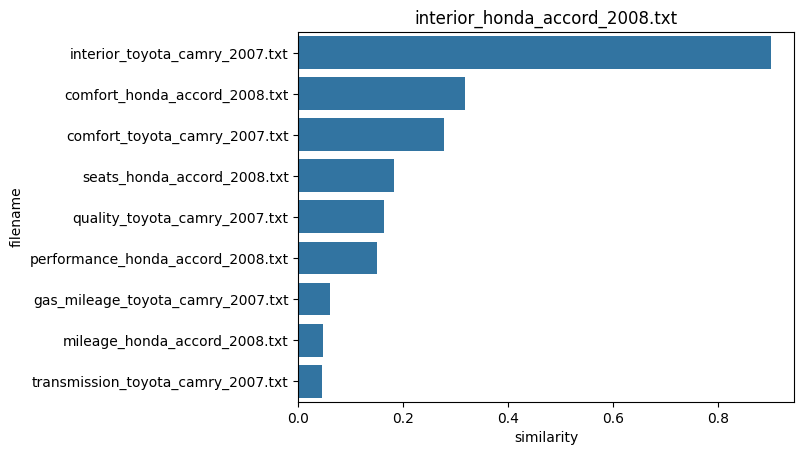

In [53]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 첫 번째 문서와 타 문서간 유사도가 큰 순으로 정렬한 인덱스를 추출하되 자기 자신은 제외.
sorted_index = similarity_pair.argsort()[:,::-1]
sorted_index = sorted_index[:,1:]

# 유사도가 큰 순으로 hotel_indexes를 추출하여 재정렬.
hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1)]

# 유사도가 큰 순으로 유사도 값을 재정렬하된 자기 자신은 제외
hotel_1_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:]

# 유사도가 큰 순으로 정렬된 인덱스와 유사도 값을 이용해 파일명과 유사도 값을 막대 그래프로 시각화
hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value
print('가장 유사도가 큰 파일명 및 유사도:\n', hotel_1_sim_df.iloc[0,:])

sns.barplot(x='similarity', y='filename', data=hotel_1_sim_df)
plt.title(comparision_docname)

##09. 한글 텍스트 처리 - 네이버 영화 평점 감성 분석

**한글 NLP 처리의 어려움**
- 한글 NLP 처리가 어려운 이유
  - 띄어쓰기 문제 -> 한글은 띄어쓰기를 잘못하면 의미가 왜곡되어 전달될 수 있음
  - 조사 문제 -> 조사는 주어나 목적어를 위해 추가되나, 경우에 수가 많아 어근 추출 등의 전처리를 진행할때 까다로움
  

**KoNLPy 소개**
- 파이썬의 대표적인 한글 형태소 패키지
  - 형태소 분석은 말뭉치를 형태소 어근 단위로 쪼개고 각 형태소에 품사 태깅을 부착하는 작업을 수행
  

**데이터 로딩**
- 영화 평점 데이터를 이용

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ratings_train.txt', sep='\t', encoding='utf-8')
train_df.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [ ]:
train_df['label'].value_counts()

,count
label,
0,75173
1,74827


In [ ]:
import re

train_df = train_df.fillna(' ')
# 정규 표현식을 이용해 숫자를 공백으로 변경(정규 표현식으로 \d는 숫자를 의미함.)
train_df['document'] = train_df['document'].apply(lambda x: re.sub(r"\d+", " ", x))

# 테스트 데이터 세트를 로디하고 동일하게 Null 및 숫자를 공백으로 변환
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ratings_test.txt', sep='\t', encoding='utf-8')
test_df = test_df.fillna(' ')
test_df['document'] = test_df['document'].apply(lambda x: re.sub(r"\d+", " ", x))

# id 칼럼 삭제 수행
train_df.drop('id', axis=1, inplace=True)
test_df.drop('id', axis=1, inplace=True)

In [ ]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 35.8 MB/s eta 0:00:00


In [ ]:
# TF-IDF 방식으로 단어를 벡터화
# 각 문장을 한글 형태소 분석을 통해 형태소 단어로 토큰화 수행
from konlpy.tag import Twitter

twitter = Twitter()
def tw_tokenizer(text):
  # 입력 인자로 들어온 텍스트를 형태소 단어로 토큰화하여 리스트 형태로 변환
  tokens_ko = twitter.morphs(text)
  return tokens_ko

/usr/local/lib/python3.12/dist-packages/konlpy/tag/_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [ ]:
# TfidfVectorizer을 이용하여 TF-IDF 피처 모델 생성하기
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Twitter 객체의 morphs() 객체를 이용한 tokenizer를 사용. ngram_range는 (1,2)
tfidf_vect = TfidfVectorizer(tokenizer=tw_tokenizer, ngram_range=(1,2), min_df=3, max_df=0.9)
tfidf_vect.fit(train_df['document'])
tfidf_matrix_train = tfidf_vect.transform(train_df['document'])

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [17]:
# 로지스틱 회귀를 이용해 감성 분석 분류 수행.
lg_clf = LogisticRegression(random_state=0, solver='liblinear')

# 파라미터 C 최적화를 위해 GridSearchCV를 이용
params = { 'C':[1, 3.5, 4.5, 5.5, 10]}
grid_cv = GridSearchCV(lg_clf, param_grid=params, cv=3, scoring='accuracy', verbose=1)
grid_cv.fit(tfidf_matrix_train, train_df['label'])
print(grid_cv.best_params_, round(grid_cv.best_score_,4))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
{'C': 3.5} 0.8593


In [18]:
from sklearn.metrics import accuracy_score

# 학습 데이터를 적용한 TfidfVectorizer를 이용해 테스트 데이터를 TF-IDF 값으로 피처 변환함
tfidf_matrix_test = tfidf_vect.transform(test_df['document'])

# classifiersms GridSearchCV에서 최적 파라미터로 학습된 classifier를 그대로 이용
best_estimator = grid_cv.best_estimator_
preds = best_estimator.predict(tfidf_matrix_test)

print('Logistic Regression 정확도:', accuracy_score(test_df['label'], preds))

Logistic Regression 정확도: 0.86172
